In [21]:
import requests
import json
import pandas as pd

In [2]:
raw_data = {
    # Length-for-age boys
    'lfa_boys': requests.get('https://www.who.int/childgrowth/standards/tab_lhfa_boys_p_0_2.txt').text,
    # Length-for-age girls
    'lfa_girls': requests.get('https://www.who.int/childgrowth/standards/tab_lhfa_girls_p_0_2.txt').text,
    # Height-for-age boys
    'hfa_boys': requests.get('https://www.who.int/childgrowth/standards/tab_lhfa_boys_p_2_5.txt').text,
    # Height-for-age girls
    'hfa_girls': requests.get('https://www.who.int/childgrowth/standards/tab_lhfa_girls_p_2_5.txt').text,
    # Weight-for-age boys
    'wfa_boys': requests.get('https://www.who.int/childgrowth/standards/tab_wfa_boys_p_0_5.txt').text,
    # Weight-for-age girls
    'wfa_girls': requests.get('https://www.who.int/childgrowth/standards/tab_wfa_girls_p_0_5.txt').text,
    # Head-circumference-for-age boys
    'hcfa_boys': requests.get('https://www.who.int/childgrowth/standards/second_set/tab_hcfa_boys_p_0_5.txt').text,
    # Head-circumference-for-age girls
    'hcfa_girls': requests.get('https://www.who.int/childgrowth/standards/second_set/tab_hcfa_girls_p_0_5.txt').text,
    # Weight-for-length boys
    'wfl_boys': requests.get('https://www.who.int/childgrowth/standards/tab_wfl_boys_p_0_2.txt').text,
    # Weight-for-length girls
    'wfl_girls': requests.get('https://www.who.int/childgrowth/standards/tab_wfl_girls_p_0_2.txt').text,
    # Weight-for-height boys
    'wfh_boys': requests.get('https://www.who.int/childgrowth/standards/tab_wfh_boys_p_2_5.txt').text,
    # Weight-for-height girls
    'wfh_girls': requests.get('https://www.who.int/childgrowth/standards/tab_wfh_girls_p_2_5.txt').text
}

In [4]:
data_frames = dict()

for tag, data in raw_data.items():
    # Convert data string into list of lists
    matrix = [row.split('\t') for row in data.split('\r\n')]

    # Get columns names from first row
    columns = matrix.pop(0)

    # Remove the empty row at the end
    matrix.pop()

    df = pd.DataFrame(data=matrix, columns=columns).astype('float64')

    # Turn column 1 into index
    df.index = df.iloc[:,0]
    df.drop(columns=df.columns[0], inplace=True)
    
    data_frames[tag] = df

In [17]:
# Using length-for-age for ages 0-24 and height-for-age for ages 25-60
lhfa_boys = data_frames['lfa_boys'].append(data_frames['hfa_boys'])
lhfa_girls = data_frames['lfa_girls'].append(data_frames['hfa_girls'])

# Following WHO instructions https://www.who.int/childgrowth/standards/readme_wflh_exp.pdf?ua=1
# Using weight-for-length for 45cm - 86cm and weight-for-height 87cm - 120cm
wflh_boys = data_frames['wfl_boys'].loc[45:86].append(data_frames['wfh_boys'].loc[87:120])
wflh_boys.index.rename('Length/Height', inplace=True)
wflh_girls = data_frames['wfl_girls'].loc[45:86].append(data_frames['wfh_girls'].loc[87:120])
wflh_girls.index.rename('Length/Height', inplace=True)

# Insert combined dataframes
data_frames['lhfa_boys'] = lhfa_boys
data_frames['lhfa_girls'] = lhfa_girls
data_frames['wflh_boys'] = wflh_boys
data_frames['wflh_girls'] = wflh_girls

# Remove old dataframes
del data_frames['lfa_boys']
del data_frames['lfa_girls']
del data_frames['hfa_boys']
del data_frames['hfa_girls']
del data_frames['wfl_boys']
del data_frames['wfl_girls']
del data_frames['wfh_boys']
del data_frames['wfh_girls']


In [27]:
with open('who_charts.json', 'w+') as file:
    json.dump({
        'weight-for-lengh/height': {
            'boys': data_frames['wflh_boys'].to_dict(),
            'girls': data_frames['wflh_girls'].to_dict()
        },
        'weight-for-age': {
            'boys': data_frames['wfa_boys'].to_dict(),
            'girls': data_frames['wfa_girls'].to_dict()
        },
        'head-circumference-for-age': {
            'boys': data_frames['hcfa_boys'].to_dict(),
            'girls': data_frames['hcfa_girls'].to_dict()
        },
        'weight-for-length/height': {
            'boys': data_frames['wflh_boys'].to_dict(),
            'girls': data_frames['wflh_girls'].to_dict()
        }
    }, file)


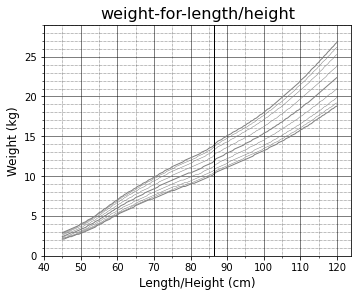

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(5.5, 4.25))

wflh_boys.plot(
    #x=wflh_b.index,
    y=['P3', 'P50', 'P97'],
    kind='line', 
    ax=ax, 
    color='gray', 
    linewidth='1'
)
wflh_boys.plot(
    #x=wflh_b.index,
    y=['P5', 'P10', 'P25', 'P75', 'P90', 'P95'],
    kind='line', 
    ax=ax, 
    color='gray', 
    linewidth='0.5'
)

ax.set_title('weight-for-length/height', color='black', fontsize=16)
ax.set_ylabel('Weight (kg)', color='black', fontsize=12)
ax.set_xlabel('Length/Height (cm)', color='black', fontsize=12)

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

start, end = ax.get_xlim()
start = 5 * round(start/5)
end = 5 * round(end/5)
ax.set_xticks(np.arange(start, end, 10))
ax.set_xticks(np.arange(start, end, 5), minor=True)

start, end = ax.get_ylim()
start = 5 * round(start/5)
end = 5 * round(end/5)
ax.set_yticks(np.arange(start, end, 5))
ax.set_yticks(np.arange(start, end, 1), minor=True)

ax.grid(which='major', linewidth='0.5', linestyle='-', color='black')
ax.grid(which='minor', linewidth='0.5', linestyle=':', color='black')

plt.axvline(x=86.5, color='black', linewidth='1')

ax.legend().remove()
